In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time


num_classes = 1
hidden_layer_size = 50
batch_size = 1
sample_size = 1
sequence_length = 1
num_LSTM_layers = 1
learning_rate = 0.0005
win = 50



def test_decoder(array, mean, stddev):
    return (array * stddev) + mean

def get_linear_layer(vector):
    return(tf.matmul(vector, Wl) + bl)
def train_test_split(X, y, train_size):
    X_train = X[:int(len(X) // (1 / train_size))]
    y_train = y[:int(len(y) // (1 / train_size))]
    X_test = X[int(len(X) // (1 / train_size)):]
    y_test = y[int(len(y) // (1 / train_size)):] 
    return X_train, X_test, y_train, y_test


def cell_list(num_LSTM_layers):
    cell_list = []
    for i in range(num_LSTM_layers):
        cell_list.append(tf.contrib.rnn.BasicLSTMCell(hidden_layer_size, forget_bias=1.0))
    return cell_list


def data_labels_shift(data, sample_size, batch_size):
    labels = data.iloc[:sample_size, 2:]
    data = data.iloc[:sample_size, 1:]
    indeces = np.random.choice(len(data), size=batch_size, replace=False)
    row = np.array(data.loc[indeces[0]][data.loc[indeces[0]][:] > 0][:-1])
    
    new_frame = np.empty([len(row) - win + 1, win])
    for i in range(len(row) - win + 1):
        new_frame[i, :] = row[i:(i + win)]
    mean = np.mean(new_frame, axis = 1).reshape(len(new_frame), 1)
    stddev = np.std(new_frame, axis = 1).reshape(len(new_frame), 1)
    
    batch_x = (new_frame[:, :win-1] - mean) / stddev
    batch_y = new_frame[:, -1]
    
    return(batch_x, batch_y, mean, stddev)


def train_test_split(X, y, train_size):
    X_train = X[:int(len(X) // (1 / train_size))]
    y_train = y[:int(len(y) // (1 / train_size))]
    X_test = X[int(len(X) // (1 / train_size)):]
    y_test = y[int(len(y) // (1 / train_size)):] 
    return X_train, X_test, y_train, y_test


def get_linear_layer(vector):
    return(tf.matmul(vector, Wl) + bl)


In [3]:
data = pd.read_csv(r"C:\M4datasets\Daily-train.csv")

batch_x, batch_y, mean_batch, stddev_batch, = data_labels_shift(data, sample_size = sample_size, batch_size = batch_size)

data_train, data_test, labels_train, labels_test = train_test_split(batch_x, batch_y, train_size = 0.8)
mean_train, mean_test, stddev_train, stddev_test = train_test_split(mean_batch, stddev_batch, train_size = 0.8)

#Наивный прогноз
print(np.mean(np.square(((data_test * stddev_test) + mean_test)[:, -1] - labels_test)))


65.62171874999994


C:\1\envs\tensorflow\lib\site-packages\tensorflow\python\client\session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Iter 0 937.03796 1771.5814
Iter 50 170.42313 646.3204
Iter 100 184.24231 506.65036
Iter 150 169.80913 317.60535
Iter 200 172.2668 242.29842
Iter 250 153.74147 169.67044
Iter 300 84.06819 164.65999
Iter 350 90.54645 187.09288
Iter 400 43.66655 171.33997
Iter 450 46.989952 118.352394
Iter 500 65.06778 125.781044
Iter 550 87.69766 232.29236
Iter 600 46.171234 146.29146
Iter 650 54.58586 129.9919
Iter 700 78.1549 152.03792
Iter 750 43.507057 115.537834
Iter 800 30.05911 97.53721
Iter 850 41.533756 94.44592
Iter 900 29.833559 82.75571
Iter 950 59.621002 97.18805
Iter 1000 35.790314 83.23775
Iter 1050 37.848114 79.95087
Iter 1100 87.27755 84.80044
Iter 1150 31.806747 82.491486
Iter 1200 32.38769 80.61127
Iter 1250 21.238787 78.35813
Iter 1300 36.22865 84.723045
Iter 1350 20.446135 75.988914
Iter 1400 29.349852 80.36499
Iter 1450 31.229795 75.01445
Iter 1500 14.865569 76.833015
Iter 1550 20.93518 130.05026
Iter 1600 75.66479 213.41777
Iter 1650 53.645523 98.03767
Iter 1700 68.59977 256.17917


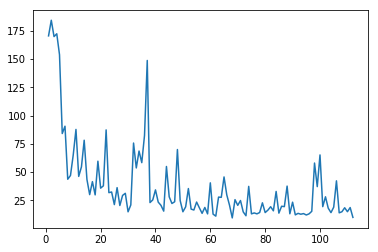

In [15]:
tf.reset_default_graph()
minibatch_size = 50
test_size = len(data_test)

with tf.name_scope("Training_data"):
    inputs = tf.placeholder(tf.float32,shape=[minibatch_size, win-1 , sequence_length])
    inputs_test = tf.placeholder(tf.float32,shape=[test_size, win-1 , sequence_length])
    
    y = tf.placeholder(tf.float32, shape=[minibatch_size])
    y_test = tf.placeholder(tf.float32, shape=[test_size])

with tf.variable_scope('LSTM_cell'):  
    cell = tf.contrib.rnn.MultiRNNCell(cells=cell_list(num_LSTM_layers), state_is_tuple=True)
    outputs, states = tf.nn.dynamic_rnn(cell, inputs, dtype=tf.float32)
    outputs_test, states_test = tf.nn.dynamic_rnn(cell, inputs_test, dtype=tf.float32)

with tf.name_scope('Linear_weights_and_biases'):
    Wl = tf.Variable(tf.truncated_normal([hidden_layer_size, num_classes], mean = 0, stddev = 0.01))
    bl = tf.Variable(tf.truncated_normal([num_classes], mean = 0, stddev = 0.1))


with tf.name_scope('Means_and_standard_deviations'):
    mean = tf.placeholder(tf.float32, shape = [minibatch_size])
    stddev = tf.placeholder(tf.float32, shape = [minibatch_size])
    
    mean_2 = tf.placeholder(tf.float32, shape = [test_size])
    stddev_2 = tf.placeholder(tf.float32, shape = [test_size])


outputs = tf.reshape(outputs, [-1, hidden_layer_size])
linear_output = tf.reshape(get_linear_layer(outputs), [minibatch_size, win-1])

final_output = test_decoder(linear_output[:, -1], mean, stddev)
mse = tf.reduce_mean(tf.squared_difference(final_output, y))
train_step = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(mse)

#Тестовые функции
outputs_test = tf.reshape(outputs_test, [-1, hidden_layer_size])
linear_output_test = tf.reshape(get_linear_layer(outputs_test), [test_size, win-1])

final_output_test = test_decoder(linear_output_test[:, -1], mean_2, stddev_2)
mse_test = tf.reduce_mean(tf.squared_difference(final_output_test, y_test))


sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
mse_list = []
min_mse = 10**10
for i in range(20000):
    indeces = np.random.choice(len(data_train), size=minibatch_size, replace=False)
    minibatch_x = data_train[indeces].reshape(minibatch_size, win-1, sequence_length)
    minibatch_y = labels_train[indeces].reshape(minibatch_size)
    mean_train_shuffle = mean_train[indeces].reshape(minibatch_size)
    stddev_train_shuffle = stddev_train[indeces].reshape(minibatch_size)
    
    
    data_test = data_test.reshape(test_size, win-1 , sequence_length)
    labels_test = labels_test.reshape(test_size)
    
    mean_test = mean_test.reshape(test_size)
    stddev_test = stddev_test.reshape(test_size)
    
    sess.run(train_step, feed_dict = {inputs : minibatch_x,\
                                            y : minibatch_y,  mean : mean_train_shuffle, stddev : stddev_train_shuffle})
    
    mse_batch = sess.run(mse, feed_dict = {inputs : minibatch_x,\
                                            y : minibatch_y,  mean : mean_train_shuffle, stddev : stddev_train_shuffle})
    
    mse_prob = sess.run(mse_test, feed_dict = {inputs_test : data_test,\
                                            y_test : labels_test,  mean_2 : mean_test, stddev_2 : stddev_test})
    if min_mse > mse_prob:
        min_mse = mse_prob
    if  i % 50 == 0:
        print("Iter", i, mse_batch, mse_prob)
        mse_list.append(mse_batch)
    if mse_prob < 44:
        break

x = range(1, len(mse_list))
plt.plot(x, mse_list[1:])
plt.show()  


In [16]:
print(min_mse)

43.818222


In [ ]:
x = range(50, len(mse_list))
plt.plot(x, mse_list[50:])
plt.show()  

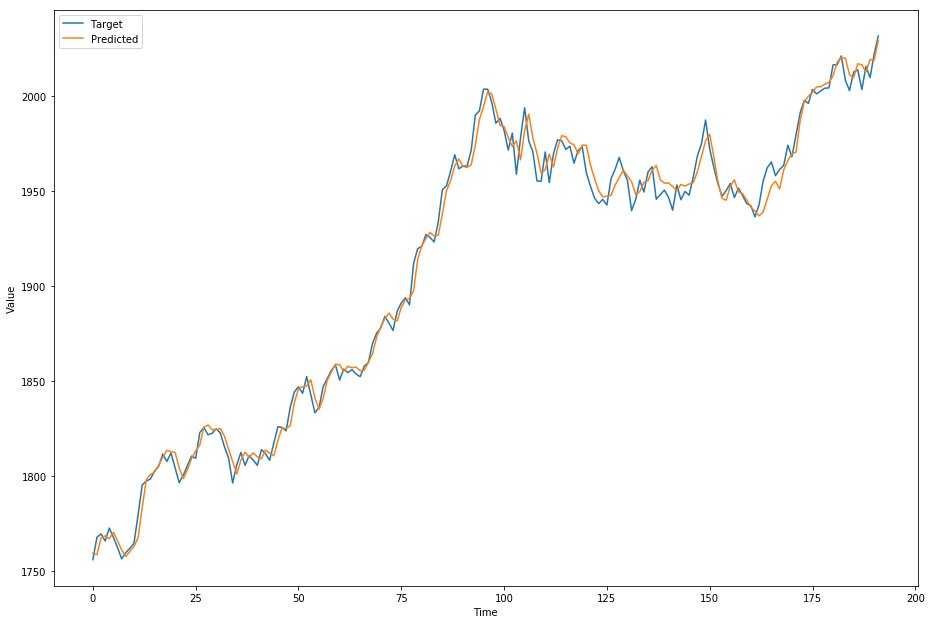

In [17]:
x = range(0, len(data_test))
fig = plt.figure(figsize = [15,10])
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(x, labels_test, label = "Target")
axes.plot(x, sess.run(final_output_test, feed_dict = {inputs_test : data_test,\
                                            y_test : labels_test,  mean_2 : mean_test, stddev_2 : stddev_test}), label = "Predicted")
axes.set_xlabel("Time")
axes.set_ylabel("Value")
axes.legend()
fig.savefig("50", dpi=200)
plt.show() 